In [2]:
import os
import os.path as osp
import copy
import glob
import pickle
import numpy as np
import pandas as pd
import torch
from nilearn import plotting, image
from nilearn.datasets import fetch_atlas_aal
from group_lasso import GroupLasso
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error as MSE
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
from mylib.sparse_modeling import sparsegrouplassocv
from mylib.config import CFG
from mylib.visualization import cluster_separation
from net.braingnn import Network3layers
from mylib.utils import seed_worker

In [3]:
seed_worker()

In [4]:
atlas_data = fetch_atlas_aal()
atlas_filename = atlas_data.maps
labels = atlas_data.labels

In [5]:
clustering_results = [
    "../log/model1/model1clustering_results.pkl",
    "../log/model2/model2clustering_results.pkl",
    "../log/model3/model3clustering_results.pkl",
    "../log/model4/model4clustering_results.pkl"
]

In [10]:
def get_cluster_idx(clustering_result):
    clstr_idx = [0] * len(labels)
    for i, roi_list in enumerate(clustering_result.values()):
        for roi in roi_list:
            clstr_idx[labels.index(roi)] = i + 1
    return clstr_idx

In [16]:
path_sub = CFG.path_subinfo
path_data = CFG.path_features
df_sub = pd.read_csv(path_sub, header = 0, index_col = 0)
fc_matrices = np.load(path_data)['pearson']
print(fc_matrices.shape)
n_sub = fc_matrices.shape[0]
n_roi = fc_matrices.shape[1]
fcs_all = []
for i in range(n_sub):
    fc_mat = fc_matrices[i]
    # thresholding r > 0.2(Seplucre et al., 2010)
    fc_mat[fc_mat <= 0.2] = 0
    # fc matrix - diad(fc matrix), 対角成分の1を除去
    fc_mat -= np.eye(n_roi)
    # calc FCS
    fcs = np.sum(fc_mat, axis = 0)
    fcs = (fcs - np.mean(fcs)) / np.std(fcs) # 被験者内で標準化しzスコア化
    fcs_all.append(fcs)
fcs_all = np.array(fcs_all)
labels_csv = pd.read_csv("../dataset/AAL/labels_and_networks_aal.csv", skiprows = 1)
labels = labels_csv.iloc[:, 1].tolist()
df_fcs = pd.DataFrame(fcs_all, columns=labels)
df_data = pd.concat([df_sub,df_fcs], axis = 1)
print(df_data.shape)
col = df_data.pop("gm_bhq")
df_data.insert(loc = 1, column = 'gm_bhq', value = col) # 扱いやすさの問題で並び替え
df_data[df_data["gender"] == "R"]
df_data.pop("handedness")
df_data = df_data[df_data["gender"] != "R"]
# 性別の情報をlabel encodingする
le = LabelEncoder()
df_data["gender"] = le.fit_transform(df_data["gender"].values)
df_data.head() # 女性が0,男性が1

(1246, 116, 116)
(1246, 121)


,subID,gm_bhq,Age,gender,Precentral_L,Precentral_R,Frontal_Sup_L,Frontal_Sup_R,Frontal_Sup_Orb_L,Frontal_Sup_Orb_R,...,Cerebelum_10_L,Cerebelum_10_R,Vermis_1_2,Vermis_3,Vermis_4_5,Vermis_6,Vermis_7,Vermis_8,Vermis_9,Vermis_10
0,A00008326,79.072081,59.0,0,0.495980,0.250095,0.714459,1.768467,0.347011,1.279448,...,-1.927155,-2.070019,-0.105018,-0.832144,-0.446375,-0.368700,-0.307247,-0.602174,-1.131039,-1.817403
1,A00013809,77.914274,61.0,0,-1.517884,-1.388616,-0.089861,0.821743,0.447050,0.511212,...,-1.423088,-2.006539,-1.307175,-1.091020,0.756108,-0.473798,-1.012259,0.574929,0.084893,-1.726529
2,A00018030,120.568090,11.0,0,-0.668970,0.217389,1.244044,1.372001,0.686713,1.293009,...,-2.062044,-1.726162,-1.919689,-0.760823,-1.594348,-1.649127,-1.504243,-0.668424,0.252358,-1.038141
3,A00019903,80.515547,83.0,1,0.947089,0.814863,0.691531,1.097538,-0.588478,-1.066423,...,-2.394462,-1.243158,-2.077314,-1.368949,-0.167131,-1.051724,-0.699194,-0.244610,-1.214180,-1.953869
4,A00023510,100.810935,23.0,1,-0.478006,-1.068308,0.055253,-0.808167,0.787673,-0.513270,...,0.466257,-1.428585,0.138575,0.039284,0.760420,-0.107239,0.866584,1.294284,-0.408794,-2.038848


In [17]:
def get_freq(columns, coef_list, group_ids):
    freq = np.zeros(len(columns))
    for c in coef_list:
        mask = np.where(c != 0, 1, 0)
        freq += mask.squeeze()
    return freq
def plot_result(output, alpha, model_number):
    new_line = "\n"
    _pm = r"$\pm$"
    fig = plt.figure(figsize = (6,6))
    plt.scatter(output["lambdas"], output["mean"], marker = "o", s = 10, color="red")
    plt.errorbar(
        output["lambdas"], 
        output["mean"], 
        label = f"best score : {output['best_score']:.5f}{_pm}{output['best_score_std']:.5f}\
            {new_line}best param : {output['best_param']['lambda']:.5f}",
        yerr = output["std"], 
        capsize=2, 
        color = "red",
        ecolor='k',
        ms=5,
        mfc='None',
        mec='k'
        )
    plt.xscale("log")
    plt.xlabel(r"log($\lambda$)")
    plt.ylabel("Mean Squared Error")
    plt.title(f"Cross validation result : {alpha}(Model {model_number})")
    plt.grid()
    plt.legend()
    plt.show()

[0.   0.25 0.5  0.75 1.  ]
[1 / 5]
best params : {'lambda': 0.005179474679231213, 'alpha': 0.0}


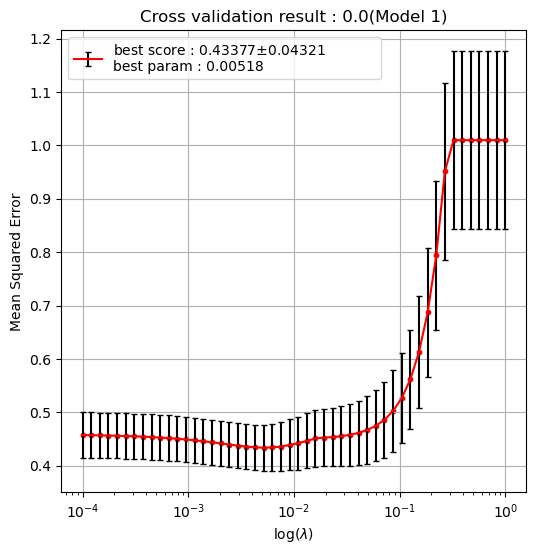

[2 / 5]
best params : {'lambda': 0.0062505519252739694, 'alpha': 0.25}


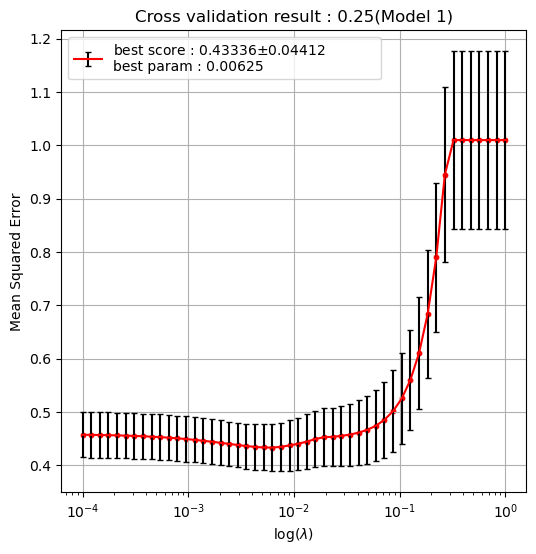

[3 / 5]
best params : {'lambda': 0.0062505519252739694, 'alpha': 0.5}


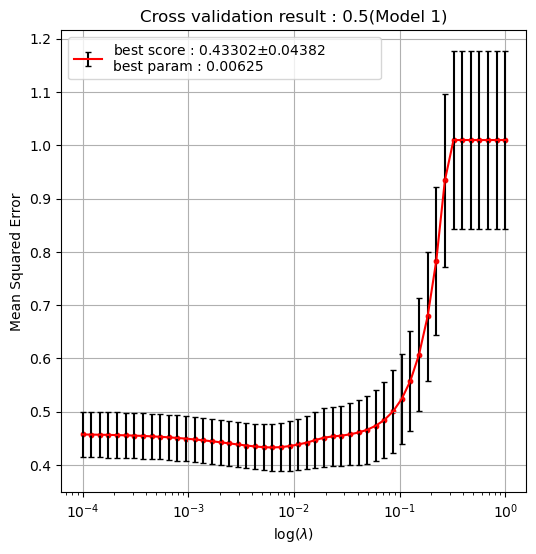

[4 / 5]


In [20]:
for i, file in enumerate(clustering_results):
    with open(file, 'rb') as p:
        result = pickle.load(p)
    clstr_idx = get_cluster_idx(result)
    group_ids = copy.deepcopy(clstr_idx)
    group_ids[0:0] = [0,0] # 被験者情報を追加(年齢と性別、group id = 0とする)   
    outputs_all = []
    idx_list_all = []
    best_coefs_all = []
    alphas = np.arange(0, 1.25, 0.25)
    print(alphas)
    n_splits = 10
    n_lambdas = 50
    for j, alpha in enumerate(alphas):
        print(f"[{j + 1} / {len(alphas)}]")
        output = sparsegrouplassocv(
            df_data,
            group_ids = group_ids,
            n_splits = n_splits,
            n_lambdas = n_lambdas,
            alpha = alpha,
            pheno = True    
        )
        outputs_all.append(output)
        print(f"best params : {output['best_param']}")
        idx = int(np.where(output["lambdas"] == output["best_param"]["lambda"])[0])
        idx_list_all.append(idx)
        best_coefs = output["coef"][idx * n_splits: (idx + 1) * n_splits]
        best_coefs_all.append(best_coefs)
        freq = get_freq(
            columns = df_data.columns[2:],
            coef_list = best_coefs, 
            group_ids = group_ids
        )
        plot_result(output, alpha, i + 1)
        title = f"sparse_result_{j + 1}.pickle"
        out_dir = f"../log/model{i + 1}"
        title = osp.join(out_dir, title)
        result_dict = {
            "best_param": output["best_param"],
            "bestcoefs" : best_coefs,
            "freq" : freq,
            "group_ids": group_ids,
            }
        with open(title, mode="wb") as f:
            pickle.dump(result_dict, f)

In [ ]:
# features
feature_names = df_data.columns[2:]
print(feature_names)
print(len(feature_names))

Index(['Age', 'gender', 'Precentral_L', 'Precentral_R', 'Frontal_Sup_L',
       'Frontal_Sup_R', 'Frontal_Sup_Orb_L', 'Frontal_Sup_Orb_R',
       'Frontal_Mid_L', 'Frontal_Mid_R',
       ...
       'Cerebelum_10_L', 'Cerebelum_10_R', 'Vermis_1_2', 'Vermis_3',
       'Vermis_4_5', 'Vermis_6', 'Vermis_7', 'Vermis_8', 'Vermis_9',
       'Vermis_10'],
      dtype='object', length=118)
118


In [ ]:
dirs = [
    "../log/model1",
    "../log/model2",
    "../log/model3",
    "../log/model4",
]
sparse_files = [
    "sparse_result_1.pickle",
    "sparse_result_2.pickle",
    "sparse_result_3.pickle",
    "sparse_result_4.pickle",
    "sparse_result_5.pickle"
]

In [ ]:
for i, d in enumerate(dirs):
    for j, f in enumerate(sparse_files):
        with open(osp.join(d, f), 'rb') as p:
            res = pickle.load(p)
        best_coefs = np.array(res["bestcoefs"])
        freqs = np.sum(np.where(best_coefs != 0, 1, 0), axis = 0).flatten()
        mean_coefs = np.mean(best_coefs, axis = 0).flatten()
        abs_coefs = np.abs(mean_coefs)
        group_ids = res["group_ids"]
        df_res = pd.DataFrame({
            "feature" : feature_names,
            "group_id" : group_ids,
            "coef" : mean_coefs,
            "abs_coef" : abs_coefs,
            "freq" : freqs
        })
        df_name = osp.join(d, f"model{i+1}_sparse{j+1}.csv")
        df_res.to_csv(df_name)

In [ ]:
def plot_bar(data, title):
    unique_ids = np.sort(data["group_id"][2:].unique())
    interval = 1 / len(unique_ids)
    cmap_org = []
    cmap = plt.get_cmap('tab10')
    for num in np.arange(0, len(unique_ids)):
        position = interval * num  # カラーマップ上の位置は 0～1 の範囲で設定する。
        cmap_org.append(cmap(position))
    colors = [cmap_org[i - 1] for i in data["group_id"][2:]]
    cmap2cluster = [f"cluster {i + 1}" for i in range(len(unique_ids))]
    print(cmap2cluster)
    handles = [Patch(facecolor=cmap_org[i], label=j) for i,j in enumerate(cmap2cluster)]
    fig, ax = plt.subplots(2, 2)
    fig.subplots_adjust(left=0.2)
    features = range(116)
    ax.bar(features, data["abs_coef"][2:], color = colors)
    ax.set_xlabel("ROI defined in AAL")
    ax.set_ylabel("abolute value of coefficient")
    ax.set_xlim(-1, 118)
    plt.title(title)
    plt.legend(handles=handles)
    plt.show()

In [ ]:
csvs_model1 = sorted(glob.glob("../log/model1/*.csv"))
csvs_model2 = sorted(glob.glob("../log/model2/*.csv"))
csvs_model3 = sorted(glob.glob("../log/model3/*.csv"))
csvs_model4 = sorted(glob.glob("../log/model4/*.csv"))

In [ ]:
def plot_bars(path_list, title = ""):
    csvs = [pd.read_csv(c, index_col = 0) for c in path_list]
    # 凡例用のcmapとを生成
    unique_ids = np.sort(csvs[0]["group_id"][2:].unique())
    interval = 1 / len(unique_ids)
    cmap_org = []
    cmap = plt.get_cmap('tab10')
    for num in np.arange(0, len(unique_ids)):
        position = interval * num  # カラーマップ上の位置は 0～1 の範囲で設定する。
        cmap_org.append(cmap(position))
    colors = [cmap_org[i - 1] for i in csvs[0]["group_id"][2:]]
    cmap2cluster = [f"cluster {i + 1}" for i in range(len(unique_ids))]
    handles = [Patch(facecolor=cmap_org[i], label=j) for i,j in enumerate(cmap2cluster)]
    # x軸用
    features = range(116)
    alphas = [0, 0.25, 0.5, 0.75]
    # 描画
    fig, axes = plt.subplots(2,2, figsize=(10,10), tight_layout=True)
    # 位置して医用
    loc = [[0, 0], [0, 1], [1, 0], [1, 1]]
    for i, l in enumerate(loc):
        axes[l[0]][l[1]].bar(features, csvs[i]["abs_coef"][2:], color = colors)
        axes[l[0]][l[1]].set_xlabel("ROI defined in AAL", fontsize = 15)
        axes[l[0]][l[1]].set_ylabel("abolute value of coefficient", fontsize = 15)
        axes[l[0]][l[1]].set_xlim(-1, 118)
        axes[l[0]][l[1]].set_title(f"alpha = {alphas[i]}")
    plt.legend(handles = handles, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize = 12)
    fig.suptitle(title, fontsize = 15)
    plt.show()

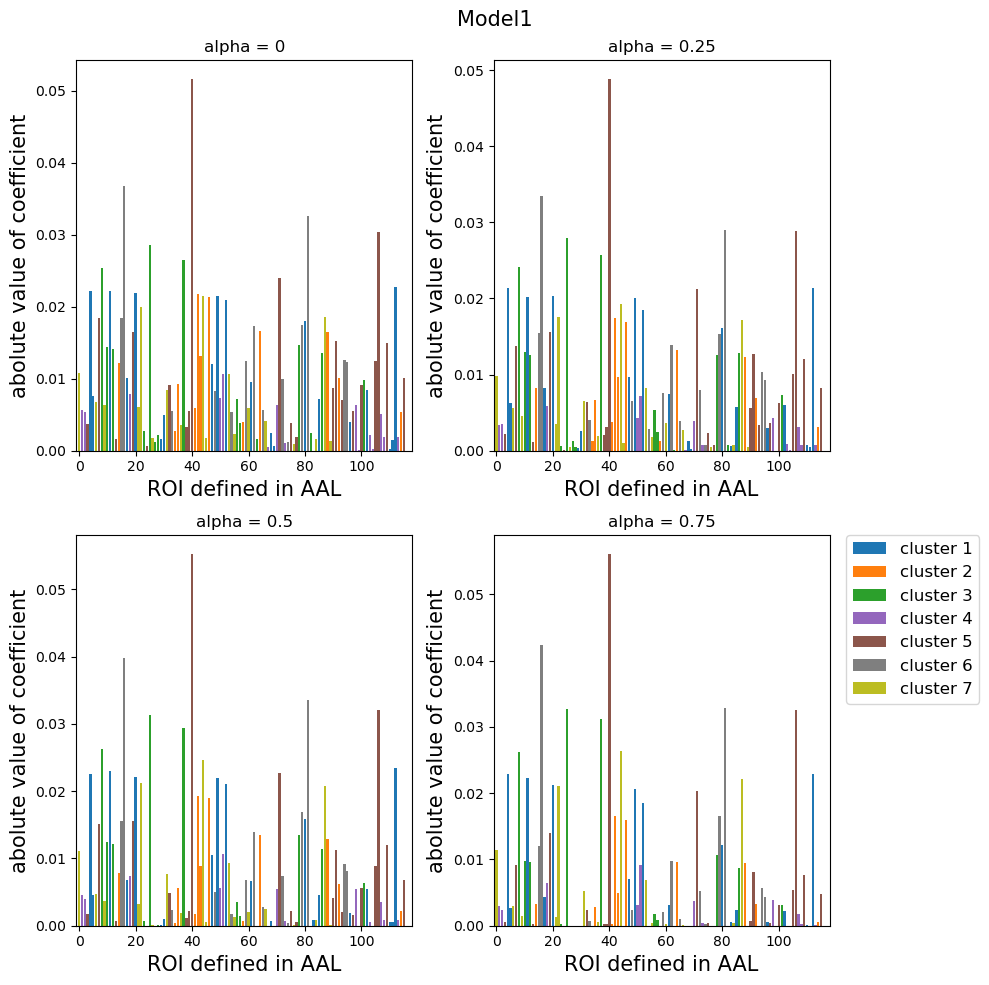

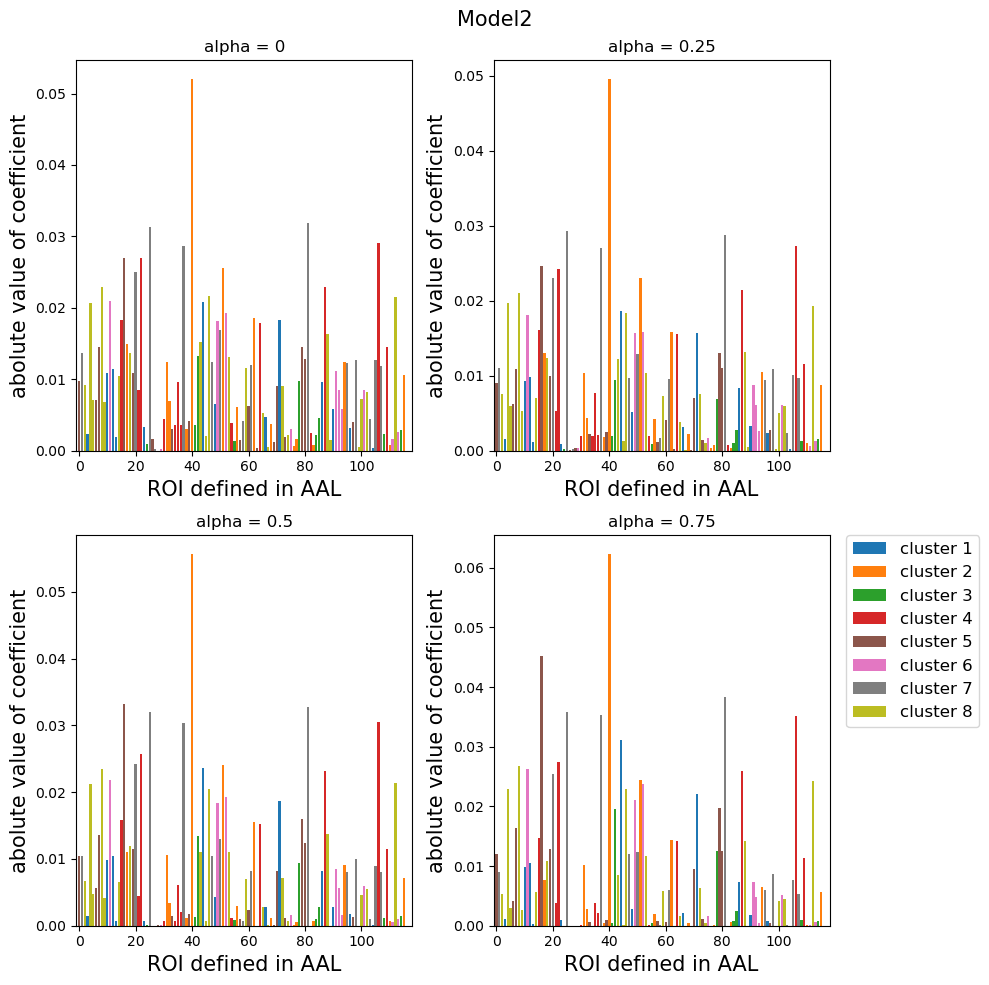

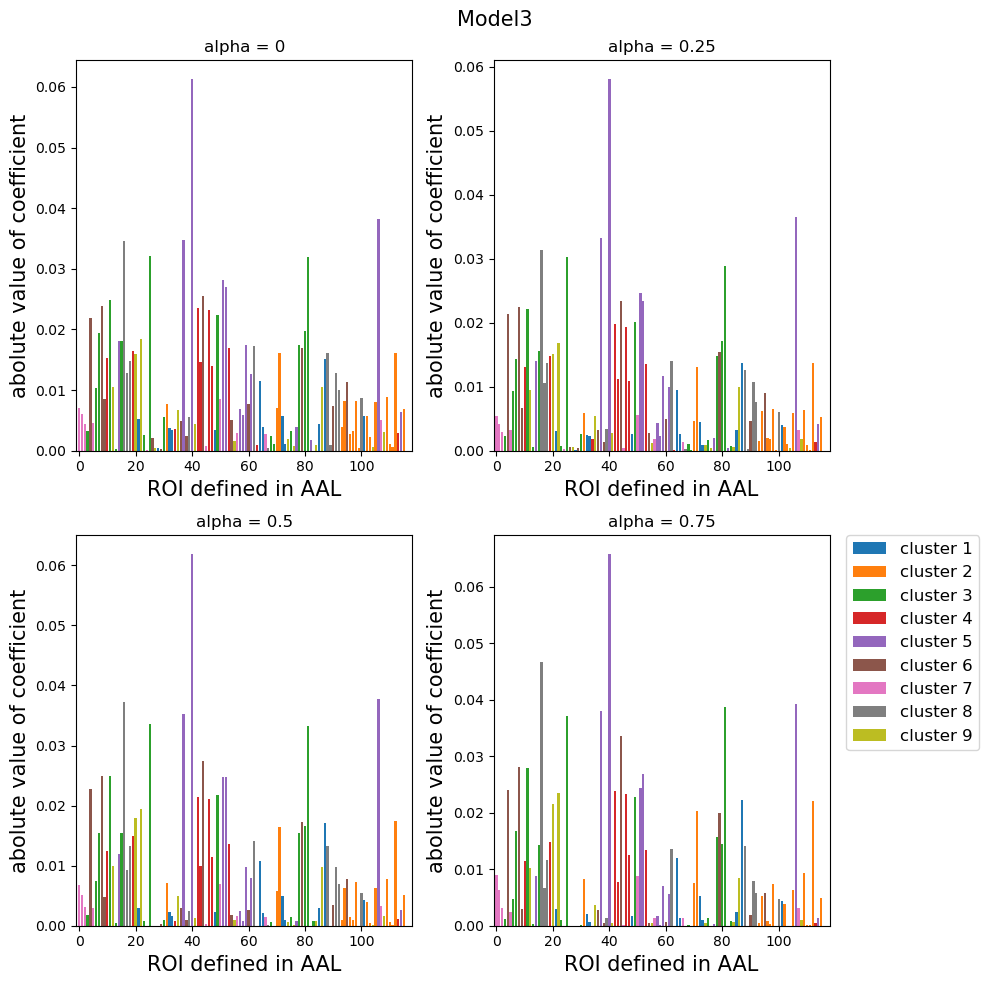

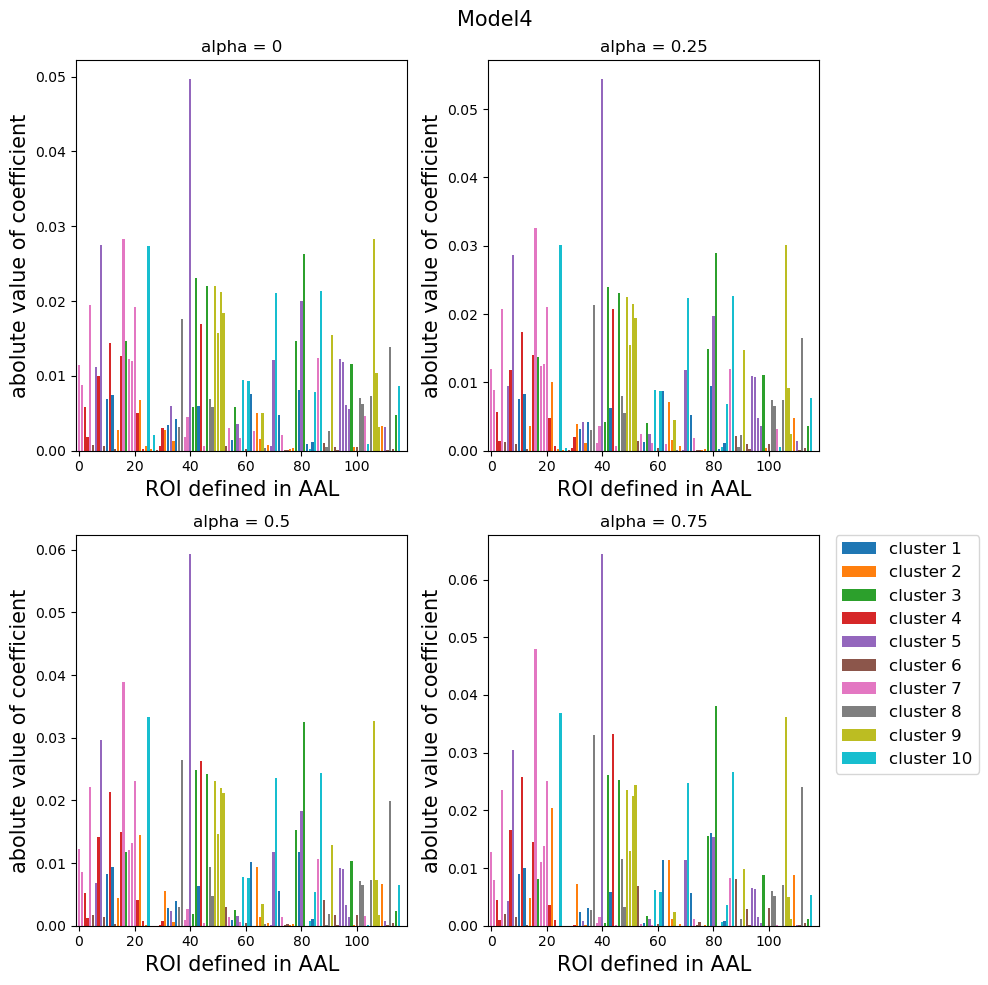

In [ ]:
plot_bars(path_list = csvs_model1, title = "Model1")
plot_bars(path_list = csvs_model2, title = "Model2")
plot_bars(path_list = csvs_model3, title = "Model3")
plot_bars(path_list = csvs_model4, title = "Model4")

In [ ]:
def lassocv(
    data, n_splits=10, n_lambdas=50, pheno=True
):
    kf = KFold(n_splits=n_splits)
    scaler = StandardScaler()
    lambdas = np.logspace(-4, 0, num=n_lambdas)
    mean_list = []
    std_list = []
    sem_list = []
    coef_list = []
    best_score = 1e5
    for c in lambdas:
        mse_list = []
        for n_fold, (train_idx, test_idx) in enumerate(kf.split(data)):
            # print(f"========================== {n_fold + 1} / {n_splits} ==========================")
            # subID除去,trainとtestにsplit -> 標準化
            train_data = scaler.fit_transform(data.iloc[train_idx, 1:])
            test_data = scaler.transform(data.iloc[test_idx, 1:])
            if pheno:  # FCS + (age, gender)
                X_train, y_train = train_data[:, 1:], train_data[:, 0]
                X_test, y_test = test_data[:, 1:], test_data[:, 0]
            else:  # FCSのみ
                X_train, y_train = train_data[:, 3:], train_data[:, 0]
                X_test, y_test = test_data[:, 3:], test_data[:, 0]
            reg = Lasso(
                alpha = c,
                max_iter=100000,  # 大きめにしておかないと収束しない
                random_state=42,
                fit_intercept=False,  # 標準化済みなので切片いらない
            )
            reg.fit(X_train, y_train)
            y_pred = reg.predict(X_test)
            mse = MSE(y_test, y_pred)
            mse_list.append(mse)
            coef_list.append(reg.coef_)
        mean = np.mean(mse_list)
        std = np.std(mse_list)
        sem = std / np.sqrt(len(mse_list))
        if mean < best_score:
            best_score = mean
            tmp_std = std
            best_param = {"lambda" : c}
        mean_list.append(mean)
        std_list.append(std)
        sem_list.append(sem)
    return {
        "best_param": best_param,
        "best_score": best_score,
        "best_score_std": tmp_std,
        "mean": mean_list,
        "std": std_list,
        "sem": sem_list,
        "mse": mse_list,
        "coef": coef_list,
        "lambdas": lambdas,
    }
def plot_result_lasso(output):
    new_line = "\n"
    _pm = r"$\pm$"
    fig = plt.figure(figsize = (6,6))
    plt.scatter(output["lambdas"], output["mean"], marker = "o", s = 10, color="red")
    plt.errorbar(
        output["lambdas"], 
        output["mean"], 
        label = f"best score : {output['best_score']:.5f}{_pm}{output['best_score_std']:.5f}\
            {new_line}best param : {output['best_param']['lambda']:.5f}",
        yerr = output["std"], 
        capsize=2, 
        color = "red",
        ecolor='k',
        ms=5,
        mfc='None',
        mec='k'
        )
    plt.xscale("log")
    plt.xlabel(r"log($\lambda$)")
    plt.ylabel("Mean Squared Error")
    plt.title(f"Cross validation result (lasso)")
    plt.grid()
    plt.legend()
    plt.show()

In [ ]:
n_splits = 10
n_lambdas = 50
output = lassocv(
    df_data,
    n_splits = n_splits,
    n_lambdas = n_lambdas,
    pheno = True    
)
print(f"best params : {output['best_param']}")
plot_result_lasso(output)
idx = int(np.where(output["lambdas"] == output["best_param"]["lambda"])[0])
idx_list_all.append(idx)
best_coefs = np.array(output["coef"][idx * n_splits: (idx + 1) * n_splits])
mean_coefs = np.mean(best_coefs, axis = 0).flatten()
freq = np.sum(np.where(best_coefs != 0, 1, 0), axis = 0).flatten()
title = f"lasso_result.pickle"
out_dir = f"../log/lasso"
title = osp.join(out_dir, title)
result_dict = {
    "best_param": output["best_param"],
    "bestcoefs" : best_coefs,
    "meancoefs" : mean_coefs,
    "freq" : freq,
    }
with open(title, mode="wb") as f:
    pickle.dump(result_dict, f)

NameError: name 'lassocv' is not defined

In [ ]:
with open("../log/lasso/lasso_result.pickle", 'rb') as p:
    l = pickle.load(p)
freq = l["freq"]
mean_coefs = l["meancoefs"]
abs_coefs = np.abs(mean_coefs)
df_res = pd.DataFrame({
            "feature" : feature_names,
            "coef" : mean_coefs,
            "abs_coef" : abs_coefs,
            "freq" : freqs
        })
df_name = osp.join("../log/lasso/", f"lasso_result.csv")
df_res.to_csv(df_name)

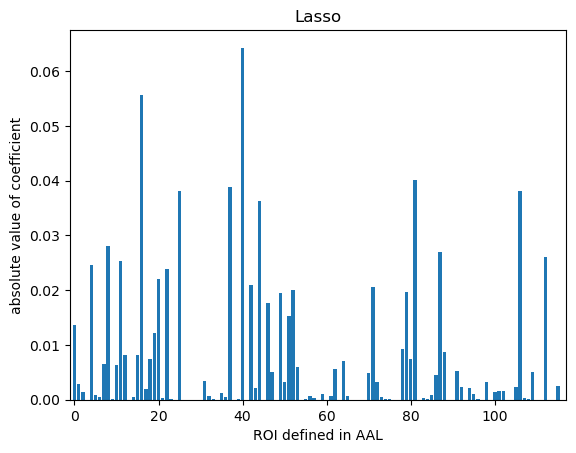

In [ ]:
features = range(116)
plt.bar(features, df_res["abs_coef"][2:])
plt.xlabel("ROI defined in AAL")
plt.ylabel("absolute value of coefficient")
plt.xlim(-1, 117)
plt.title("Lasso")
plt.show()